<a href="https://colab.research.google.com/github/Fikaaw/quantitative-finance/blob/main/garch_midas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GARCH Mix Data-Sampling (MIDAS) for Volatility Modelling and VaR Estimate

## Univariate Modelling

In [ ]:
!pip install arch pandas numpy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.api import VAR

In [ ]:
# Example: Generating synthetic data
np.random.seed(42)
daily_returns = np.random.normal(0, 1, 1000)  # High-frequency data
macro_indicator = np.random.normal(0, 1, 50)  # Low-frequency data

In [ ]:
# Create DataFrames
daily_returns_df = pd.DataFrame(daily_returns, columns=['Daily_Returns'])
macro_indicator_df = pd.DataFrame(macro_indicator, columns=['Macro_Indicator'])

# Save to CSV files
daily_returns_df.to_csv('daily_returns.csv', index=False)
macro_indicator_df.to_csv('macro_indicator.csv', index=False)

print("Data saved to 'daily_returns.csv' and 'macro_indicator.csv'")

Data saved to 'daily_returns.csv' and 'macro_indicator.csv'


In [ ]:
model = arch_model(daily_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

In [ ]:
def midas_weights(beta, K):
    weights = np.array([(1 - i / K) ** (beta - 1) for i in range(K)])
    return weights / weights.sum()

K = 22  # Number of daily observations in a month
beta = 1.5  # Hyperparameter for weighting function
weights = midas_weights(beta, K)

In [ ]:
def garch_midas(daily_returns, macro_indicator, weights):
    T = len(daily_returns)
    L = len(macro_indicator)
    long_term_component = np.zeros(T)

    for t in range(T):
        month_idx = t // K
        if month_idx >= L:
            month_idx = L - 1
        # Ensure the slice has enough elements for the dot product
        start_idx = max(0, month_idx - K + 1)
        end_idx = month_idx + 1
        if end_idx - start_idx < len(weights):
            long_term_component[t] = np.dot(weights[:end_idx - start_idx], macro_indicator[start_idx:end_idx])
        else:
            long_term_component[t] = np.dot(weights, macro_indicator[start_idx:end_idx])

    return long_term_component

long_term_component = garch_midas(daily_returns, macro_indicator, weights)

In [ ]:
combined_volatility = garch_fit.conditional_volatility * long_term_component

# Use the combined volatility for further modeling or forecasting


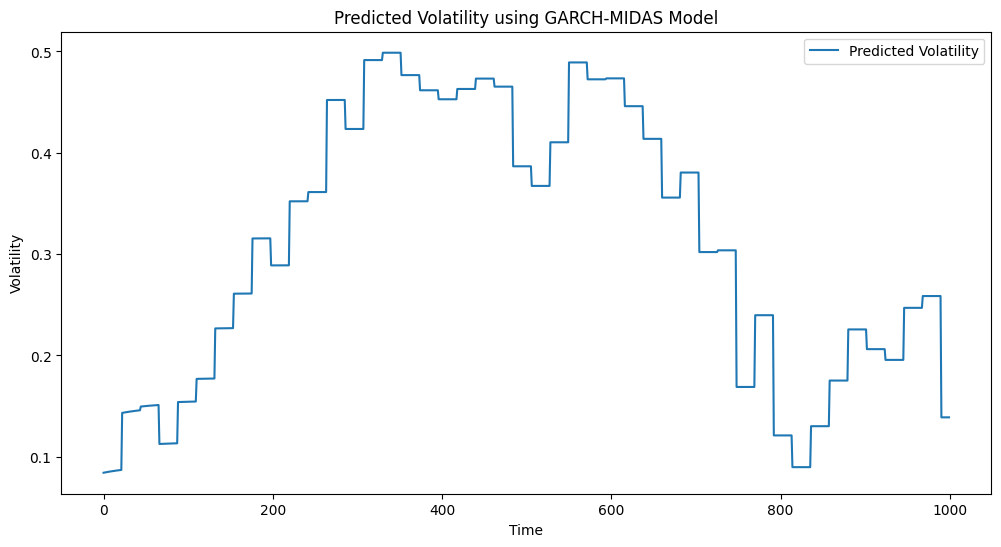

In [ ]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(combined_volatility, label='Predicted Volatility')
plt.title('Predicted Volatility using GARCH-MIDAS Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Saving the results to a CSV file
predicted_volatility = pd.DataFrame(combined_volatility, columns=['Predicted_Volatility'])
predicted_volatility.to_csv('predicted_volatility.csv', index=False)

## Asumsi-asumsi dalam Analisis Time Series
1. Stasioneritas: Data time series harus stasioner, artinya statistik dasar seperti mean dan varians tidak berubah seiring waktu.
2. Autokorelasi: Residual (kesalahan) model seharusnya tidak berkorelasi satu sama lain.
3. Normalitas Residual: Residual seharusnya mengikuti distribusi normal.
4. Homoskedastisitas: Varians residual seharusnya konstan seiring waktu.

### 1. Stasioneritas

Menggunakan uji Augmented Dickey-Fuller (ADF) untuk memeriksa stasioneritas.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Contoh penggunaan:
test_stationarity(daily_returns)

ADF Statistic: -31.81109384149144
p-value: 0.0
Critical Values:
   1%, -3.4369127451400474
Critical Values:
   5%, -2.864437475834273
Critical Values:
   10%, -2.568312754566378


### 2. Autokorelasi

Menggunakan plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF).

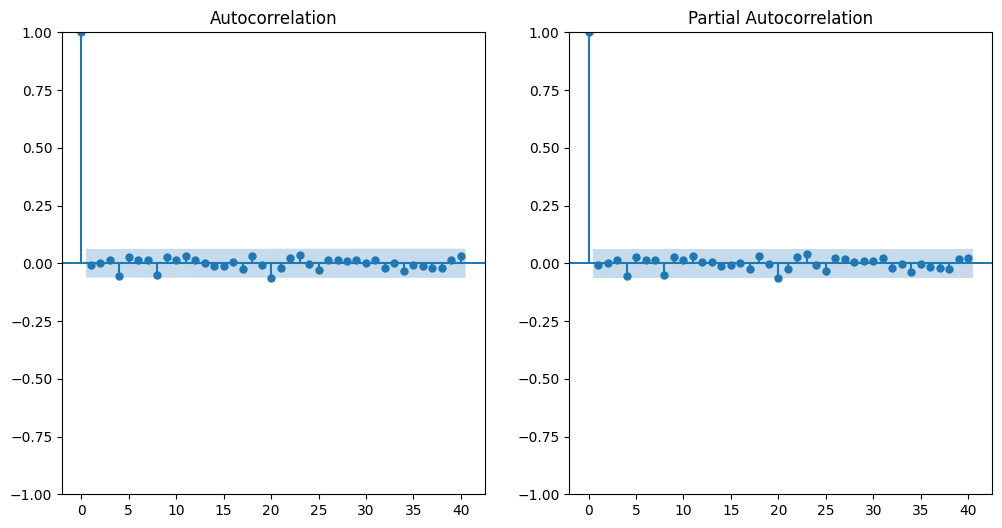

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(daily_returns, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(daily_returns, ax=plt.gca(), lags=40)
plt.show()


### 3. Normalitas Residual
Menggunakan uji Shapiro-Wilk untuk memeriksa normalitas residual.

In [ ]:
from scipy.stats import shapiro

# Mengambil residual dari model GARCH yang sudah dilatih
residuals = garch_fit.resid

stat, p = shapiro(residuals)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)


Shapiro-Wilk Test Statistic: 0.9986080527305603
p-value: 0.6264819502830505


### 4. Homoskedastisitas
Menggunakan plot residual vs fitted values untuk memeriksa homoskedastisitas.

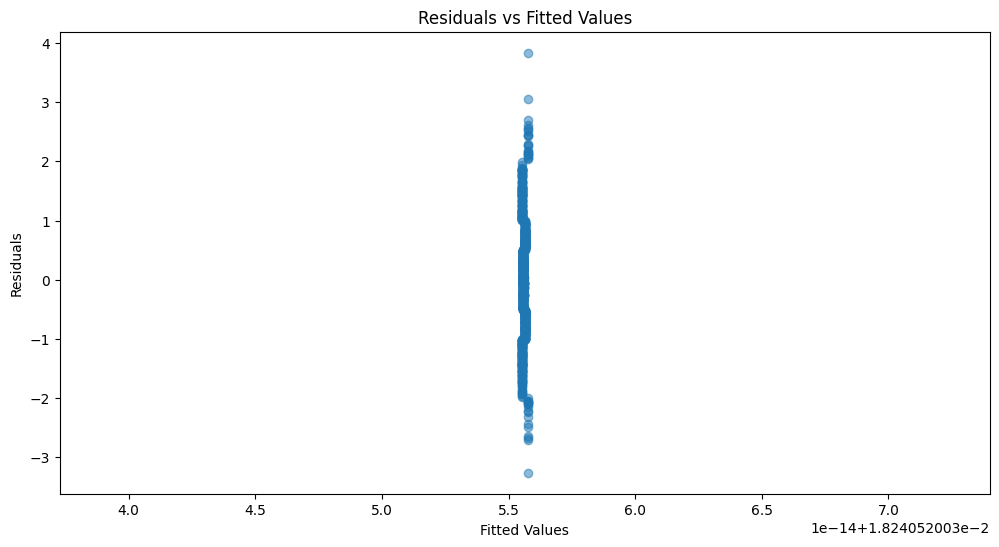

In [ ]:
import matplotlib.pyplot as plt

# Get the conditional volatility from the GARCH model
conditional_volatility = garch_fit.conditional_volatility

# Calculate the fitted values (assuming you're working with returns)
fitted_values = daily_returns - residuals

plt.figure(figsize=(12, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## Multivariate Modelling

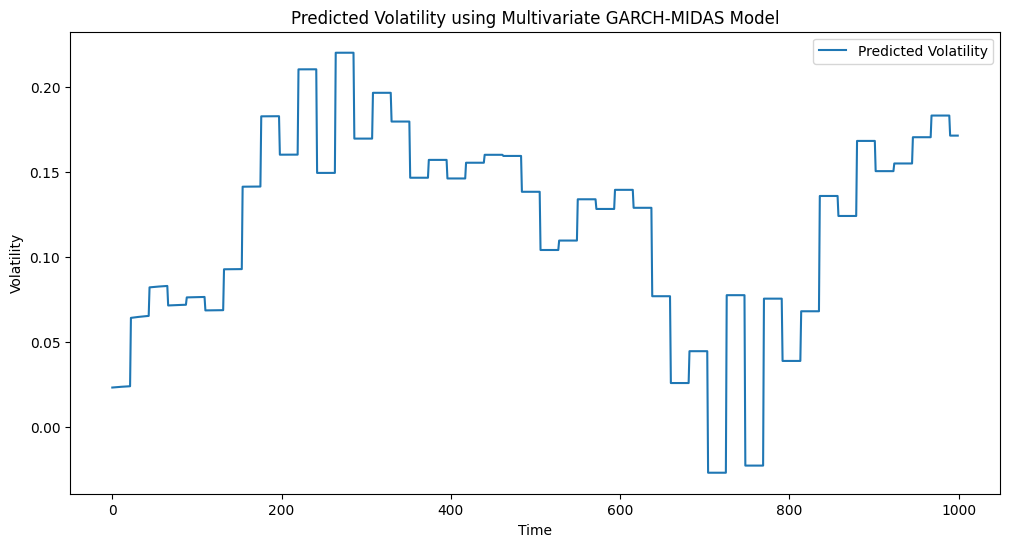

Data saved to 'predicted_volatility_multivariate.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Generate synthetic data
np.random.seed(42)
daily_returns = np.random.normal(0, 1, 1000)  # High-frequency data
macro_indicator1 = np.random.normal(0, 1, 50)  # Low-frequency data
macro_indicator2 = np.random.normal(0, 1, 50)  # Another low-frequency data

# Save the generated data to CSV files
daily_returns_df = pd.DataFrame(daily_returns, columns=['Daily_Returns'])
macro_indicator1_df = pd.DataFrame(macro_indicator1, columns=['Macro_Indicator1'])
macro_indicator2_df = pd.DataFrame(macro_indicator2, columns=['Macro_Indicator2'])

daily_returns_df.to_csv('daily_returns.csv', index=False)
macro_indicator1_df.to_csv('macro_indicator1.csv', index=False)
macro_indicator2_df.to_csv('macro_indicator2.csv', index=False)

# GARCH model for high-frequency data
model = arch_model(daily_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# MIDAS weights function
def midas_weights(beta, K):
    weights = np.array([(1 - i / K) ** (beta - 1) for i in range(K)])
    return weights / weights.sum()

K = 22  # Number of daily observations in a month
beta = 1.5  # Hyperparameter for weighting function
weights = midas_weights(beta, K)

# Combine GARCH and MIDAS for multivariate case
def garch_midas_multivariate(daily_returns, macro_indicators, weights):
    T = len(daily_returns)
    L = len(macro_indicators[0])
    long_term_component = np.zeros(T)

    for t in range(T):
        month_idx = t // K
        if month_idx >= L:
            month_idx = L - 1
        for macro in macro_indicators:
            # Extract a window of data from the macro indicator
            start_idx = max(0, month_idx - K + 1)
            end_idx = month_idx + 1
            macro_window = macro[start_idx:end_idx]

            # Pad the macro window with zeros if it's shorter than K
            if len(macro_window) < K:
                macro_window = np.pad(macro_window, (0, K - len(macro_window)))

            long_term_component[t] += np.dot(weights, macro_window) # Calculate dot product with the padded window
        long_term_component[t] /= len(macro_indicators)  # Averaging the long-term components from multiple indicators

    return long_term_component

# List of macroeconomic indicators
macro_indicators = [macro_indicator1, macro_indicator2]
long_term_component = garch_midas_multivariate(daily_returns, macro_indicators, weights)

# Combined volatility
combined_volatility = garch_fit.conditional_volatility * long_term_component

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(combined_volatility, label='Predicted Volatility')
plt.title('Predicted Volatility using Multivariate GARCH-MIDAS Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Saving the combined volatility to a CSV file
predicted_volatility = pd.DataFrame(combined_volatility, columns=['Predicted_Volatility'])
predicted_volatility.to_csv('predicted_volatility_multivariate.csv', index=False)

print("Data saved to 'predicted_volatility_multivariate.csv'")


## Uji Asumsi

Stasioneritas Daily Returns:
ADF Statistic: -31.81109384149144
p-value: 0.0
   1%, -3.4369127451400474
   5%, -2.864437475834273
   10%, -2.568312754566378


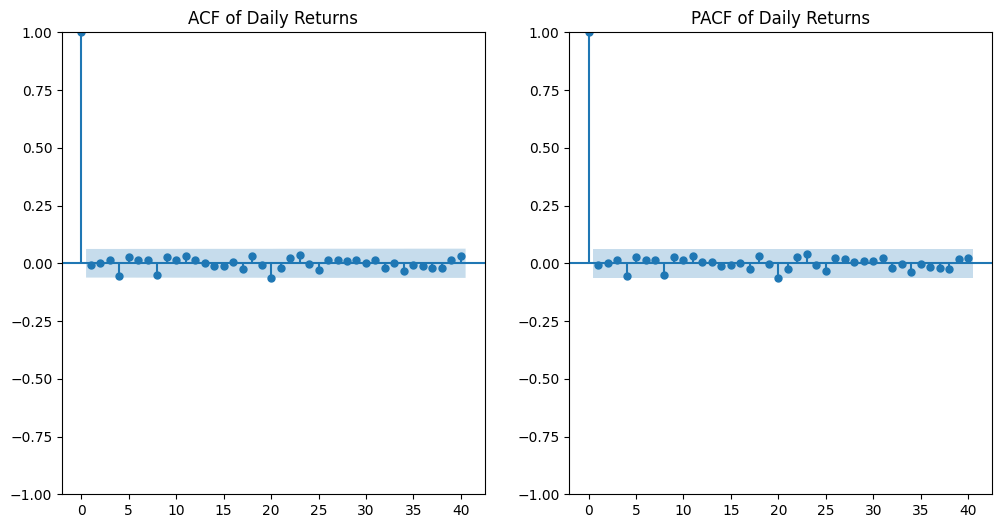

Shapiro-Wilk Test Statistic: 0.9986080527305603
p-value: 0.6264819502830505


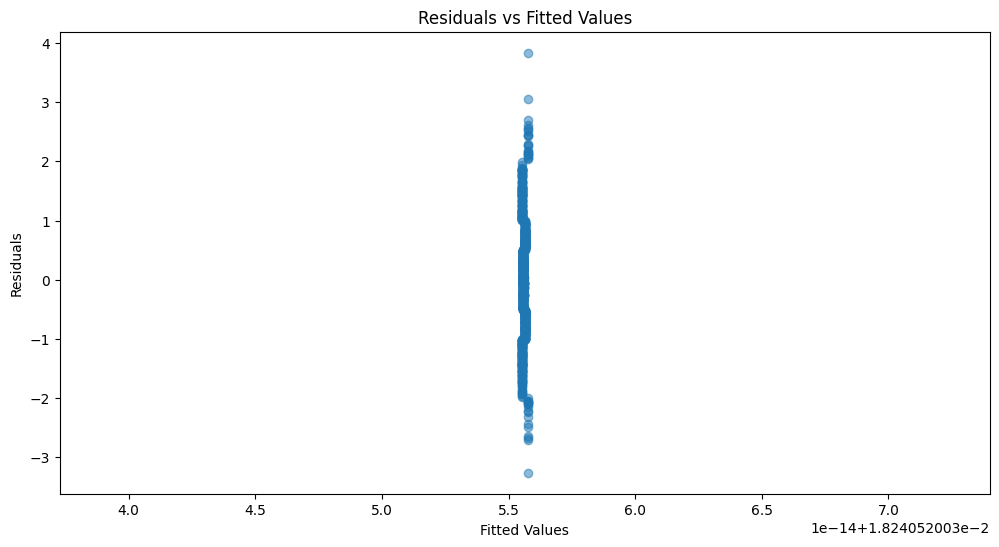

In [ ]:
# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'   {key}, {value}')

# Check stationarity
print("Stasioneritas Daily Returns:")
test_stationarity(daily_returns)

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(daily_returns, ax=plt.gca(), lags=40)
plt.title('ACF of Daily Returns')
plt.subplot(122)
plot_pacf(daily_returns, ax=plt.gca(), lags=40)
plt.title('PACF of Daily Returns')
plt.show()

# Check normality of residuals
residuals = garch_fit.resid
stat, p = shapiro(residuals)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)

# Plot residuals vs fitted values
plt.figure(figsize=(12, 6))
# Access fitted values from the residuals object
plt.scatter(daily_returns - residuals, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## Volatility Modelling with Macro and Sentiment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Generate synthetic data
np.random.seed(42)

# High-frequency return data (daily)
n_obs_daily = 1000
dates_daily = pd.date_range(start='2020-01-01', periods=n_obs_daily, freq='D')
ihsg_returns = np.random.normal(0, 1, n_obs_daily)

# Low-frequency macroeconomic data (monthly)
n_obs_monthly = 50
dates_monthly = pd.date_range(start='2020-01-01', periods=n_obs_monthly, freq='M')
inflation = np.random.normal(0, 1, n_obs_monthly)
interest_rate = np.random.normal(0, 1, n_obs_monthly)
gdp = np.random.normal(0, 1, n_obs_monthly)

# Low-frequency investor sentiment data (monthly)
turnover_rate = np.random.normal(0, 1, n_obs_monthly)
trading_volume = np.random.normal(0, 1, n_obs_monthly)
pe_ratio = np.random.normal(0, 1, n_obs_monthly)

# Create DataFrames
ihsg_df = pd.DataFrame({'IHSG_Returns': ihsg_returns}, index=dates_daily)
macro_df = pd.DataFrame({
    'Inflation': inflation,
    'Interest_Rate': interest_rate,
    'GDP': gdp
}, index=dates_monthly)
sentiment_df = pd.DataFrame({
    'Turnover_Rate': turnover_rate,
    'Trading_Volume': trading_volume,
    'PE_Ratio': pe_ratio
}, index=dates_monthly)


In [ ]:
# Define MIDAS weights function
def midas_weights(beta, K):
    weights = np.array([(1 - i / K) ** (beta - 1) for i in range(K)])
    return weights / weights.sum()

# Apply MIDAS weights
K = 22  # Number of lags for daily data to match monthly data
beta = 1.5
weights = midas_weights(beta, K)

# Expand macro_indicator to daily frequency using MIDAS weights
def expand_macro_to_daily(macro_df, daily_index, weights):
    expanded_macro = pd.DataFrame(index=daily_index)
    for col in macro_df.columns:
        expanded_macro[col] = np.zeros(len(daily_index))
        macro_values = macro_df[col].values.flatten()
        for t in range(len(daily_index)):
            month_idx = t // K
            if month_idx >= len(macro_values):
                month_idx = len(macro_values) - 1
            # Slice macro_values to get K values ending at month_idx
            relevant_macro_values = macro_values[max(0, month_idx - K + 1) : month_idx + 1]
            # Ensure that there are always K values for the dot product
            if len(relevant_macro_values) < K:
                relevant_macro_values = np.pad(
                    relevant_macro_values,
                    (0, K - len(relevant_macro_values)),
                    "constant"
                )
            expanded_macro[col].iloc[t] = np.dot(weights, relevant_macro_values)
    return expanded_macro

expanded_macro = expand_macro_to_daily(macro_df, dates_daily, weights)
expanded_sentiment = expand_macro_to_daily(sentiment_df, dates_daily, weights)
ihsg_df = ihsg_df.join(expanded_macro).join(expanded_sentiment)

In [ ]:
from arch import arch_model

# Define a function to fit GARCH-MIDAS model
def garch_midas_fit(returns, macro_factors):
    # Fit GARCH(1,1) model to returns
    garch11 = arch_model(returns, vol='Garch', p=1, q=1).fit(disp='off')

    # Compute long-term volatility component using macro factors
    long_term_vol = np.zeros_like(returns)
    for col in macro_factors.columns:
        long_term_vol += garch11.conditional_volatility * macro_factors[col]

    # Combine short-term and long-term volatility components
    combined_vol = garch11.conditional_volatility * long_term_vol
    return combined_vol

# Apply GARCH-MIDAS to IHSG returns with macroeconomic factors
macro_factors = ihsg_df[['Inflation', 'Interest_Rate', 'GDP']]
combined_vol_macro = garch_midas_fit(ihsg_df['IHSG_Returns'], macro_factors)

# Apply GARCH-MIDAS to IHSG returns with investor sentiment factors
sentiment_factors = ihsg_df[['Turnover_Rate', 'Trading_Volume', 'PE_Ratio']]
combined_vol_sentiment = garch_midas_fit(ihsg_df['IHSG_Returns'], sentiment_factors)


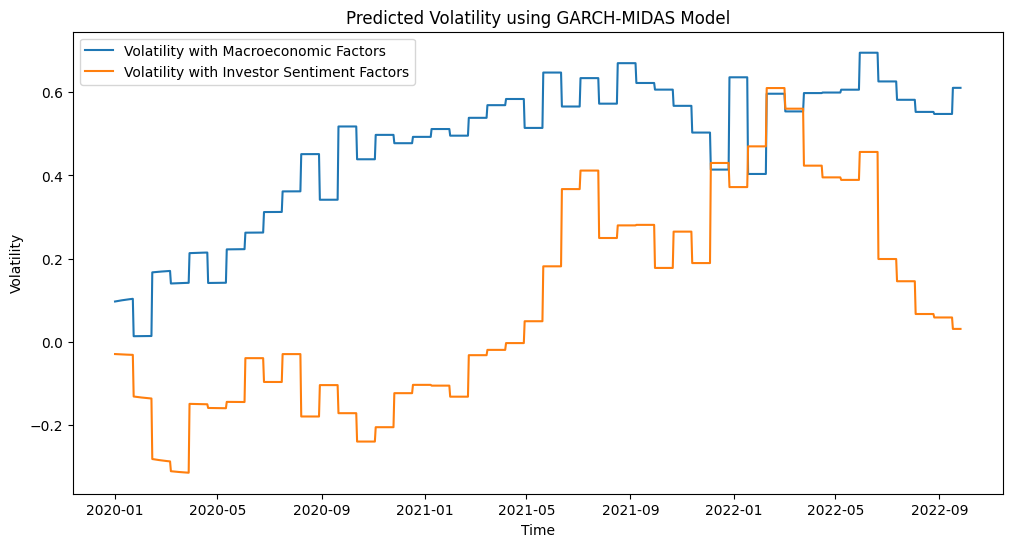

In [ ]:
# Plotting the combined volatility components
plt.figure(figsize=(12, 6))
plt.plot(combined_vol_macro, label='Volatility with Macroeconomic Factors')
plt.plot(combined_vol_sentiment, label='Volatility with Investor Sentiment Factors')
plt.title('Predicted Volatility using GARCH-MIDAS Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Estimate VaR

In [ ]:
from scipy.stats import norm

# Define a function to calculate VaR
def calculate_var(returns, vol, confidence_level=0.95):
    z_score = norm.ppf(confidence_level)
    var = -returns.mean() + z_score * vol
    return var

# Calculate VaR with macroeconomic factors
var_macro = calculate_var(ihsg_df['IHSG_Returns'], combined_vol_macro)

# Calculate VaR with investor sentiment factors
var_sentiment = calculate_var(ihsg_df['IHSG_Returns'], combined_vol_sentiment)

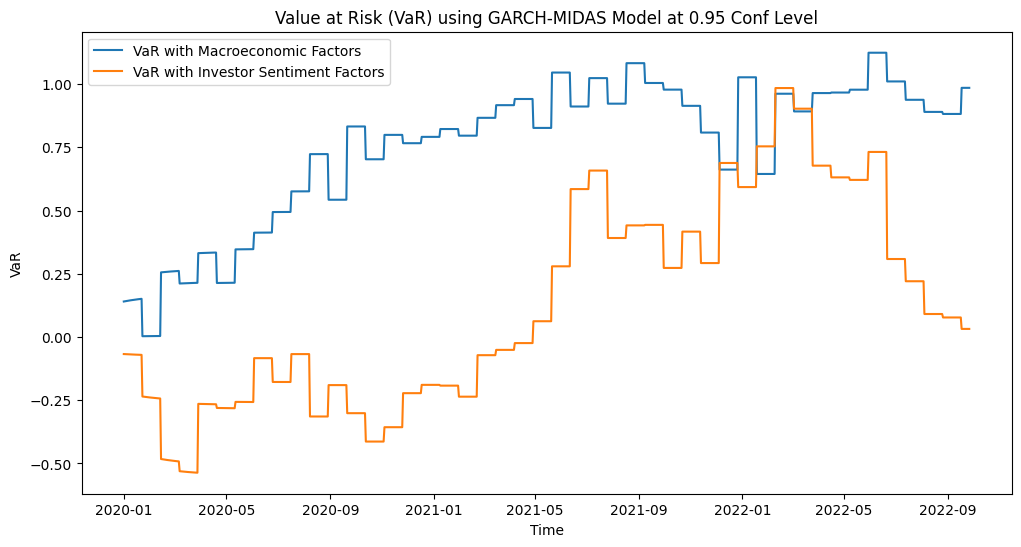

In [ ]:
# Plotting the VaR
plt.figure(figsize=(12, 6))
plt.plot(var_macro, label='VaR with Macroeconomic Factors')
plt.plot(var_sentiment, label='VaR with Investor Sentiment Factors')
plt.title('Value at Risk (VaR) using GARCH-MIDAS Model at 0.95 Conf Level')
plt.xlabel('Time')
plt.ylabel('VaR')
plt.legend()
plt.show()

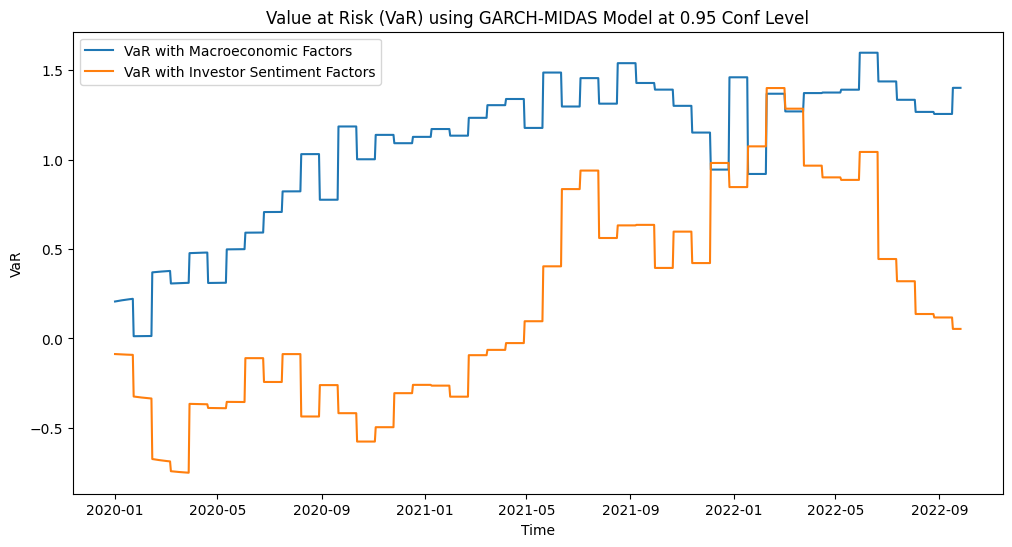

In [ ]:
from scipy.stats import norm

# Define a function to calculate VaR
def calculate_var(returns, vol, confidence_level=0.99):
    z_score = norm.ppf(confidence_level)
    var = -returns.mean() + z_score * vol
    return var

# Calculate VaR with macroeconomic factors
var_macro = calculate_var(ihsg_df['IHSG_Returns'], combined_vol_macro)

# Calculate VaR with investor sentiment factors
var_sentiment = calculate_var(ihsg_df['IHSG_Returns'], combined_vol_sentiment)
# Plotting the VaR
plt.figure(figsize=(12, 6))
plt.plot(var_macro, label='VaR with Macroeconomic Factors')
plt.plot(var_sentiment, label='VaR with Investor Sentiment Factors')
plt.title('Value at Risk (VaR) using GARCH-MIDAS Model at 0.95 Conf Level')
plt.xlabel('Time')
plt.ylabel('VaR')
plt.legend()
plt.show()

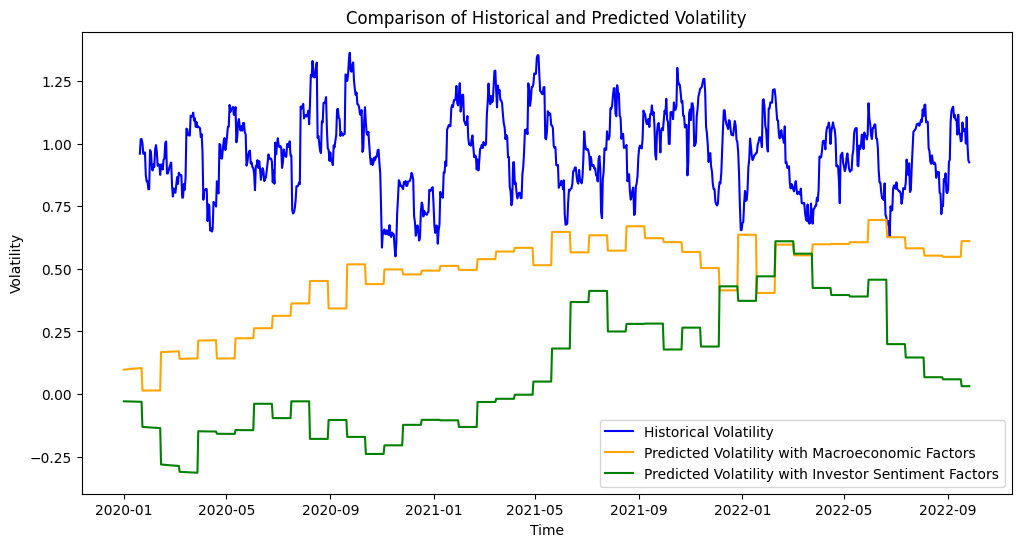

In [ ]:
# Plotting historical volatility and predicted volatilities
plt.figure(figsize=(12, 6))

window_size = 20  # Define the window size for rolling calculation
ihsg_df['Historical_Volatility'] = ihsg_df['IHSG_Returns'].rolling(window=window_size).std()
# Plot historical volatility
plt.plot(ihsg_df['Historical_Volatility'], label='Historical Volatility', color='blue')

# Plot predicted volatilities with macroeconomic factors
plt.plot(ihsg_df.index, combined_vol_macro, label='Predicted Volatility with Macroeconomic Factors', color='orange')

# Plot predicted volatilities with investor sentiment factors
plt.plot(ihsg_df.index, combined_vol_sentiment, label='Predicted Volatility with Investor Sentiment Factors', color='green')

# Plot settings
plt.title('Comparison of Historical and Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
# Membuat DataFrame dari hasil estimasi
result_df = pd.DataFrame({
    'Date': dates_daily,
    'Volatility_Macro': combined_vol_macro,
    'Volatility_Sentiment': combined_vol_sentiment,
    'VaR_Macro': var_macro,
    'VaR_Sentiment': var_sentiment
})

# Menyimpan DataFrame ke file CSV
result_df.to_csv('volatility-var-estimated.csv', index=False)